## 1. 定义算法

DQN 经验回放的算法中的均匀采样算法，可能会忘记一些重要的、以后使用的经验数据。针对这样的问题，PER_DQN 提出了优先级经验回放（prioritized experience reolay）的技术来解决，这种方法应用到 DQN 获得了更好的效果。PER_DQN 成功的原因有：1. 提出了sum tree这样复杂度为O(logn)的高效数据结构。 2. 正确估计了 weighted importance sampling. 

### 定义模型

同 DQN 。

In [43]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, n_states,n_actions,hidden_dim=128):
        """ 初始化q网络，为全连接网络
        """
        super(Model, self).__init__()
        self.fc1 = nn.Linear(n_states, hidden_dim) # 输入层
        self.fc2 = nn.Linear(hidden_dim,hidden_dim) # 隐藏层
        self.fc3 = nn.Linear(hidden_dim, n_actions) # 输出层
        
    def forward(self, x):
        # 各层对应的激活函数
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### 定义经验回放

PER核心思想是优化了经验回放的逻辑。它使用了sum tree的数据结构，它是一种特殊的二叉树，其父亲节点的值等于子节点的和。节点上的值，定义为每个样本的优先度，这里就用TDerror来衡量。叶子上的数值就是样本优先度。

sum tree 采样过程：根据根节点的priority和采样样本数，划分采样的区间，然后在这些区间中均应采样得到所要选取的样本的优先度。从根节点开始，逐层将样本的优先度和节点的优先度进行对比，最终可以得到所要采样的叶子样本。

In [44]:
import numpy as np
import random

class SumTree:
    '''SumTree for the per(Prioritized Experience Replay) DQN. 
    '''
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.data_pointer = 0
        self.n_entries = 0
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype = object)

    def update(self, tree_idx, p):
        '''Update the sampling weight
        '''
        change = p - self.tree[tree_idx]
        self.tree[tree_idx] = p

        while tree_idx != 0:
            tree_idx = (tree_idx - 1) // 2
            self.tree[tree_idx] += change

    def add(self, p, data):
        '''Adding new data to the sumTree
        '''
        tree_idx = self.data_pointer + self.capacity - 1
        self.data[self.data_pointer] = data
        # print ("tree_idx=", tree_idx)
        # print ("nonzero = ", np.count_nonzero(self.tree))
        self.update(tree_idx, p)

        self.data_pointer += 1
        if self.data_pointer >= self.capacity:
            self.data_pointer = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    def get_leaf(self, v):
        '''Sampling the data
        '''
        parent_idx = 0
        while True:
            cl_idx = 2 * parent_idx + 1
            cr_idx = cl_idx + 1
            if cl_idx >= len(self.tree):
                leaf_idx = parent_idx
                break
            else:
                if v <= self.tree[cl_idx] :
                    parent_idx = cl_idx
                else:
                    v -= self.tree[cl_idx]
                    parent_idx = cr_idx

        data_idx = leaf_idx - self.capacity + 1
        return leaf_idx, self.tree[leaf_idx], self.data[data_idx]

    def total(self):
        return int(self.tree[0])


class ReplayTree:
    '''ReplayTree for the per(Prioritized Experience Replay) DQN. 
    '''
    def __init__(self, capacity):
        self.capacity = capacity # the capacity for memory replay
        self.tree = SumTree(capacity)
        self.abs_err_upper = 1.
        ## hyper parameter for calculating the importance sampling weight
        self.beta_increment_per_sampling = 0.001
        self.alpha = 0.6
        self.beta = 0.4
        self.epsilon = 0.01 
        self.abs_err_upper = 1.

    def __len__(self):
        ''' return the num of storage
        '''
        return self.tree.total()

    def push(self, error, sample):
        '''Push the sample into the replay according to the importance sampling weight
        '''
        p = (np.abs(error) + self.epsilon) ** self.alpha
        self.tree.add(p, sample)         


    def sample(self, batch_size):
        pri_segment = self.tree.total() / batch_size
        priorities, batch, idxs, is_weights = [], [], [], []
        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])
        min_prob = np.min(self.tree.tree[-self.tree.capacity:]) / self.tree.total() 

        for i in range(batch_size):
            a = pri_segment * i
            b = pri_segment * (i+1)
            s = random.uniform(a, b)
            idx, p, data = self.tree.get_leaf(s)

            priorities.append(p)
            batch.append(data)
            idxs.append(idx)
            prob = p / self.tree.total()

        sampling_probabilities = np.array(priorities) / self.tree.total()
        is_weights = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
        is_weights /= is_weights.max()

        return zip(*batch), idxs, is_weights
    
    def batch_update(self, tree_idx, abs_errors):
        '''Update the importance sampling weight
        '''
        abs_errors += self.epsilon

        clipped_errors = np.minimum(abs_errors, self.abs_err_upper)
        ps = np.power(clipped_errors, self.alpha)

        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)

### 定义策略

同 DQN 。

In [45]:
import torch
import torch.optim as optim
import math
import numpy as np


class Policy:
    def __init__(self, cfg):
        self.action_dim = cfg.action_dim  
        self.device = torch.device(cfg.device) 
        self.gamma = cfg.gamma  
        ## e-greedy策略相关参数
        self.sample_count = 0  # 用于epsilon的衰减计数
        self.epsilon = cfg.epsilon_start
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.batch_size = cfg.batch_size
        self.target_update = cfg.target_update
        self.policy_net = Model(cfg.state_dim,cfg.action_dim,hidden_dim=cfg.hidden_dim).to(self.device)
        self.target_net = Model(cfg.state_dim,cfg.action_dim,hidden_dim=cfg.hidden_dim).to(self.device)
        ## 复制参数到目标网络
        for target_param, param in zip(self.target_net.parameters(),self.policy_net.parameters()): 
            target_param.data.copy_(param.data)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg.lr) 
        self.memory = ReplayTree(cfg.buffer_size) # 经验回放
        self.update_cnt = 0
        
    def sample_action(self, state):
        ''' sample action with e-greedy policy
        '''
        self.sample_count += 1
        # epsilon 指数衰减
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) 
        if random.random() > self.epsilon:
            with torch.no_grad():
                state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
                q_values = self.policy_net(state)
                action = q_values.max(1)[1].item() # 根据Q值选择动作
        else:
            action = random.randrange(self.action_dim)
        return action

    def predict_action(self,state):
        ''' 预测动作
        '''
        with torch.no_grad():
            state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
            q_values = self.policy_net(state)
            action = q_values.max(1)[1].item() 
        return action
    def update(self):
        if len(self.memory) < self.batch_size: # 不满足一个批量时，不更新策略
            return
        # 采样一个batch
        (state_batch, action_batch, reward_batch, next_state_batch, done_batch), idxs_batch, is_weights_batch = self.memory.sample(
            self.batch_size)
        state_batch = torch.tensor(np.array(state_batch), device=self.device, dtype=torch.float) # shape(batchsize,n_states)
        action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(1) # shape(batchsize,1)
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float).unsqueeze(1) # shape(batchsize,1)
        next_state_batch = torch.tensor(np.array(next_state_batch), device=self.device, dtype=torch.float) # shape(batchsize,n_states)
        done_batch = torch.tensor(np.float32(done_batch), device=self.device).unsqueeze(1) # shape(batchsize,1)
        q_value_batch = self.policy_net(state_batch).gather(dim=1, index=action_batch) # shape(batchsize,1),requires_grad=True
        next_max_q_value_batch = self.target_net(next_state_batch).max(1)[0].detach().unsqueeze(1) 
        expected_q_value_batch = reward_batch + self.gamma * next_max_q_value_batch* (1-done_batch)

        # loss中根据优先度进行了加权
        loss = torch.mean(torch.pow((q_value_batch - expected_q_value_batch) * torch.from_numpy(is_weights_batch).to(self.device), 2))

        # loss = nn.MSELoss()(q_value_batch, expected_q_value_batch)   

        abs_errors = np.sum(np.abs(q_value_batch.cpu().detach().numpy() - expected_q_value_batch.cpu().detach().numpy()), axis=1)
        # 需要更新样本的优先度
        self.memory.batch_update(idxs_batch, abs_errors) 

        # 反向传播
        self.optimizer.zero_grad()  
        loss.backward()
        # 梯度截断，防止梯度爆炸
        for param in self.policy_net.parameters():  
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step() 
        self.update_cnt += 1
        if self.update_cnt % self.target_update == 0: # 更新 target_net
            self.target_net.load_state_dict(self.policy_net.state_dict()) 


### 定义训练

In [46]:

import gymnasium as gym

def train(cfg):
    ''' 训练
    '''
    env = gym.make(cfg.env_id)
    setattr(cfg, "action_space", env.action_space)
    setattr(cfg, "state_dim", env.observation_space.shape[0])
    setattr(cfg, "action_dim", env.action_space.n)
    policy = Policy(cfg)
    rewards = []  # 记录所有回合的奖励
    frames = []
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state, info = env.reset(seed = cfg.seed)  # 重置环境，返回初始状态
        for _ in range(cfg.max_steps):
            ep_step += 1
            action = policy.sample_action(state)  # 选择动作
            next_state, reward, terminated, truncated , info = env.step(action)  # 更新环境，返回transition
            ## PER DQN 特有的内容
            policy_val = policy.policy_net(torch.tensor(state, device = cfg.device))[action]
            target_val = policy.target_net(torch.tensor(next_state, device = cfg.device))
            if truncated:
                error = abs(policy_val - reward)
            else:
                error = abs(policy_val - reward - cfg.gamma * torch.max(target_val))
            policy.memory.push(error.cpu().detach().numpy(), (state, action, reward,
                            next_state, truncated))   # 保存transition
            state = next_state  # 更新下一个状态
            policy.update()  # 更新智能体
            ep_reward += reward  # 累加奖励
            if terminated:
                break
        rewards.append(ep_reward)
        frames.append(i_ep)
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}，Epislon：{policy.epsilon:.3f}")
    env.close()
    return {'rewards':rewards, 'frames':frames}

### 设置参数

In [47]:
class Config:
    def __init__(self) -> None:
        self.algo_name = 'PER_DQN' # 算法名称
        self.env_id = 'CartPole-v1' # 环境id
        self.mode = 'train'
        self.seed = 1 # 随机种子，便于复现，0表示不设置
        self.train_eps = 100 # 训练的回合数
        self.test_eps = 20 # 测试的回合数
        self.max_steps = 200 # 每个回合的最大步数，超过该数则游戏强制终止
        self.gamma = 0.95 # 折扣因子
        self.epsilon_start = 0.95 # e-greedy策略中初始epsilon
        self.epsilon_end = 0.01 # e-greedy策略中的终止epsilon
        self.epsilon_decay = 500 # e-greedy策略中epsilon的衰减率
        self.buffer_size = 100000 # 经验回放池的容量
        self.hidden_dim = 256 # 神经网络的隐藏层维度
        self.batch_size = 64 # 批次大小
        self.target_update = 100 # 目标网络的更新频率
        self.lr = 0.0001 # 学习率
        self.device = 'cpu' if not torch.cuda.is_available() else 'cuda'

### 开始训练

Hyperparameters:
        Name        	       Value        	        Type        
     algo_name      	        DQN         	   <class 'str'>    
       env_id       	    CartPole-v1     	   <class 'str'>    
        mode        	       train        	   <class 'str'>    
        seed        	         1          	   <class 'int'>    
     train_eps      	        100         	   <class 'int'>    
      test_eps      	         20         	   <class 'int'>    
     max_steps      	        200         	   <class 'int'>    
       gamma        	        0.95        	  <class 'float'>   
   epsilon_start    	        0.95        	  <class 'float'>   
    epsilon_end     	        0.01        	  <class 'float'>   
   epsilon_decay    	        500         	   <class 'int'>    
    buffer_size     	       100000       	   <class 'int'>    
     hidden_dim     	        256         	   <class 'int'>    
     batch_size     	         64         	   <class 'int'>    
   target_update    	        100      

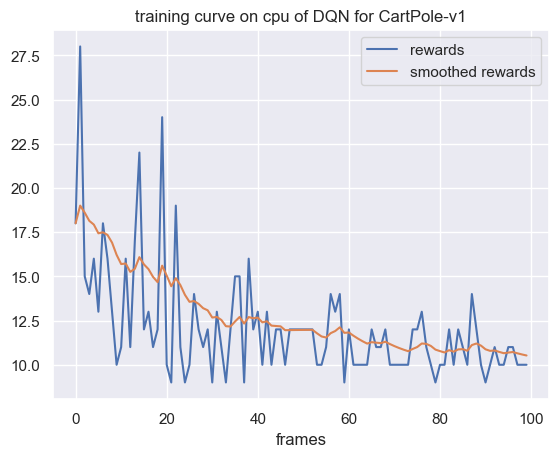

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

def smooth(data: list, weight: float = 0.9):
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(cfg, frames, rewards):
    ''' 画图
    '''
    sns.set_theme(style="darkgrid")
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{cfg.mode}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_id}")
    plt.xlabel('frames')
    plt.plot(frames, rewards, label='rewards')
    plt.plot(frames, smooth(rewards), label='smoothed rewards')
    plt.legend()
    plt.show()

def print_cfgs(cfg):
    ''' 打印参数
    '''
    cfg_dict = vars(cfg)
    print("Hyperparameters:")
    print(''.join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("Name", "Value", "Type"))
    for k,v in cfg_dict.items():
        if v.__class__.__name__ == 'list':
            v = str(v)
        print(tplt.format(k,v,str(type(v))))   
    print(''.join(['=']*80))

def all_seed(seed: int = 0):
    ''' 设置随机种子
    '''
    if seed == 0:
        return
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False  

# 获取参数
cfg = Config() 
all_seed(cfg.seed)
print_cfgs(cfg)
res = train(cfg)
plot_rewards(cfg, res['frames'], res['rewards'])